# A practical introduction into quantum signal processing (QSP)

In this notebook we are going to implement and run the single-qubit quantum circuits used to illustrate quantum signal processing in [arXiv:2110.11327](https://arxiv.org/abs/2110.11327) and [arXiv:2105.02859](https://arxiv.org/abs/2105.02859).
Quantum signal processing is a systematic framework to transform quantum systems with respect to almost arbitrary polynomial functions.

We first include some functions from Qiskit, NumPy, SymPy, as well as Matplotlib.

In [1]:
from qiskit import QuantumCircuit, execute, transpile
from qiskit.providers.basicaer import UnitarySimulatorPy
from qiskit.tools.monitor import job_monitor

import numpy as np
import numpy.random as random

import sympy as sp

import matplotlib.pyplot as plt

from math import acos

## 1. QSP polynomials

To illustrate quantum signal processing, consider a sequence in which we alternate a *signal* rotation operator
$$ W(x) = \begin{pmatrix} x & \mathrm{i}\sqrt{1 - x^2} \\ \mathrm{i}\sqrt{1 - x^2} & x \end{pmatrix} $$
for a *fixed* value $x \in [1, -1]$ and a *processing* rotation operator
$$ S(\phi) = e^{\mathrm{i}\phi Z} $$
for variable real numbers $\phi$.  These two matrices are unitary and can be implemented using $R_x(-2\cos^{-1} x) = W(x)$ and $R_z(-2 \phi) = S(\phi)$ operations as follows.

In [2]:
class WGate(QuantumCircuit):
    """Defines the W(x) gate in terms of a Rx rotation"""
    def __init__(self, x):
        super().__init__(1)

        super().rx(-2.0 * acos(x), 0)

class SGate(QuantumCircuit):
    """Defines the S(ɸ) gate in terms of a Rz rotation"""
    def __init__(self, phi):
        super().__init__(1)

        super().rz(-2.0 * phi, 0)

We also define two functions that compute the matrices explicitly as defined above.  We are using SymPy here, so we can later evaluate them symbolically to create various polynomials.

In [3]:
def expected_w(x):
    """Return W(x) as a SymPy matrix"""
    return sp.Matrix([[x, 1j * sp.sqrt(1 - x**2)], [1j * sp.sqrt(1 - x**2), x]])

def expected_s(phi):
    """Return S(x) as a SymPy matrix"""
    return sp.diag([sp.exp(1j * phi), sp.exp(-1j * phi)], unpack=True)

Let's now test whether the `WGate` and the `SGate` do compute the expected matrices.  For this purpose, we create quantum circuits with a single gate and random values for $x$ and $\phi$ and compare the unitary of the circuit with the expected unitary from the function.

In [4]:
# Create Qiskit backend to obtain unitary matrices from quantum circuits
unitary_backend = UnitarySimulatorPy()

# Check for 100 random numbers
for _ in range(100):
    # Draw an x in [-1, 1] to test WGate
    x = random.rand() * 2 - 1

    circ = QuantumCircuit(1)
    circ.append(WGate(x), [0])

    # Run circuit and return unitary matrix
    actual = execute(circ, unitary_backend).result().get_unitary()

    # Expected result from definition (transforms SymPy matrix into NumPy array)
    expected = np.array(expected_w(x).evalf()).astype(complex)

    assert np.allclose(actual, expected)


    # Draw a ɸ in [0, 2π] to test SGate
    phi = random.rand() * np.pi

    circ = QuantumCircuit(1)
    circ.append(SGate(phi), [0])

    # Run circuit and return unitary matrix
    actual = execute(circ, unitary_backend).result().get_unitary()

    # Expected result from definition (transforms SymPy matrix into NumPy array)
    expected = np.array(expected_s(phi).evalf()).astype(complex)

    assert np.allclose(actual, expected)

print("All tests passed.")

All tests passed.


Now that we have a better understanding of $W(x)$ and $S(\phi)$, let's get back to quantum signal processing, or short QSP.
For a set of so-called *QSP phases* $\vec \phi = (\phi_0, \dots, \phi_d)$ we can construct the unitary matrix
$$ U^{\vec\phi} = S(\phi_0)\prod_{i=1}^d W(x) S(\phi_i) = \begin{pmatrix} P(x) & \mathrm{i}Q(x) \sqrt{1-x^2} \\ \mathrm{i}Q^*(x)\sqrt{1-x^2} & P^*(x) \end{pmatrix}$$
for some polynomials $P(x)$ and $Q(x)$ such that $\mathrm{deg}(P) \le d$, $\mathrm{deg}(Q) < d$.  You can find more details about this remarkable result in [arXiv:1603.03996](https://arxiv.org/abs/1603.03996).

Also the inverse direction works! Given any polynomial $P(x)$ that fulfills the requirement properties and some error bound $\epsilon$ we can find QSP phases $\vec\phi$ from which we can build the alternating gate sequence $U^{\vec\phi}$.  Algorithms to find these phases are described, e.g., in [arXiv:1806.10236](https://arxiv.org/abs/1806.10236) and [arXiv:2003.02831](https://arxiv.org/abs/2003.02831).  But instead of using such approaches to find phases for some polynomial, we are picking some phases and use whatever polynomial results from them in our experiments.

In [5]:
def qsp_polynomial(x, phases):
    """
    Given 𝑑 + 1 QSP phases ɸ[0], ..., ɸ[𝑑], returns the unitary matrix U^ɸ as described above,
    the polynomial in its top-left corner, and the expression in the top-right corner."""
    assert phases, "phases cannot be empty"

    poly = expected_s(phases[0])

    for phi in phases[1:]:
        poly = poly * expected_w(x) * expected_s(phi)
    
    poly = sp.simplify(poly)
    return poly, poly[0, 0], poly[0, 1]

Let's use this functions to create a polynomial of degree 1 with phases $0.1$, $0.2$, $0.3$, and $0.4$.

In [6]:
# For now we want the polynomial symbolically for some variable 𝑥
x = sp.Symbol('x')
phases = [0.1, 0.2, 0.3, 0.4]

# For our first experiment we do not need the polynomial in the top-right corner
U, poly, _ = qsp_polynomial(x, phases)

poly

x*(-1.0*(1 - x**2)*(1.92106099400289 + 0.389418342308651*I) + (1.0*x**2 + x**2*exp(0.4*I) - 1.0)*exp(0.6*I))

Let's also plot the squared magnitude $|P(x)|^2$ of this polynomial in the range $x \in [-1, 1]$.

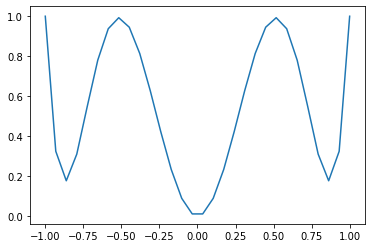

In [7]:
# translate amplitude polynomial into probability polynomial
poly_abs = sp.Abs(poly)**2

# discretization points (this will correspond to the number of quantum jobs)
discretization_points = 30

xs = np.linspace(-1, 1, discretization_points)
ys = [poly_abs.evalf(subs={'x': x}) for x in xs]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(xs, ys)
plt.show()

## 2. Simulating the QSP polynomial with a quantum circuit

Next, we are creating the quantum circuit using $W$ and $S$ gates that is supposed to implement our target unitary with the QSP polynomial $P$ in the top-left corner.

In [8]:
def qsp_circuit(x, phases):
    """Creates a single-qubit unitary for some given QSP phases"""

    # Map SumPy phases into NumPy phases and reverse them (gate application
    # direction is opposite to matrix multiplication)
    np_phases = [float(phi) for phi in phases]
    np_phases.reverse()

    circ = QuantumCircuit(1)

    # We need to apply gates in reverse order to matrix multiplication
    circ.append(SGate(np_phases[0]), [0])  # apply last angle
    for phi in np_phases[1:]:           # iterate through all but last angle in reverse order
        circ.append(WGate(x), [0])
        circ.append(SGate(phi), [0])

    return circ

We simulate the unitary matrices of QSP circuits constructed for some random values of $x \in [-1, 1]$ and compare them to the unitary $U$ that we explicitly constructed above.

In [9]:
# Test QSP polynomial
for _ in range(10):
    x = random.rand() * 2.0 - 1.0

    # Create circuit
    circ = qsp_circuit(x, phases)

    # Run circuit and return unitary matrix
    actual = execute(circ, unitary_backend).result().get_unitary()

    # Expected result from U by plugging in x value for x symbol (transforms SymPy matrix into NumPy array)
    expected = np.array(U.evalf(subs={'x': x})).astype(complex)

    assert np.allclose(actual, expected)

Great, the test passes! This means we should be able to reconstruct the polynomial $|P(x)|^2$ that we plotted above by running the QSP circuit several times and estimate the measurement probability of receiving $|0\rangle$ from various measurement results iterating through different values for $x$.
We set ourselves up by first creating a function that takes as input a quantum circuit that can be parameterized for a value $x$ a set of values from which we draw $x$, as well as a number of shots that indicates how many times the circuit is run for each $x$.
The function returns a list of measurement probabilities that approximate $|P(x)|^2$ based on running the QSP circuit.

The reason that we approximate the probability of measuring $|0\rangle$ is because we obtain $P(x) = \langle 0|U^{\vec\phi} |0\rangle$, i.e., as a projection to the top-left corner.

For the upcoming experiments we are going to simulate the QSP polynomial on a quantum computing backend.
To do this, we connect to the Azure Quantum service.
We construct an instance of the `AzureQuantumProvider`. Note that it's imported from `azure.quantum.qiskit`.

In [10]:
# Create a backend for quantum circuit simulation (e.g., ionq_simulator or ionq_qpu)
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "",
    location = ""
)

In [11]:
# List all available targets
print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

# Select ionq.simulator target
backend = provider.get_backend("ionq.simulator")

This workspace's targets:
- honeywell.hqs-lt-s1
- honeywell.hqs-lt-s1-apival
- honeywell.hqs-lt-s2
- honeywell.hqs-lt-s2-apival
- honeywell.hqs-lt-s1-sim
- ionq.qpu
- ionq.simulator


In [12]:
def simulate_polynomial(circuit_function, xs, num_shots):
    """
    This function creates experiment circuits for each `x` in `xs`,
    simulates them for the given number of shots and returns a list
    of measurement probabilities for each input value `x`.
    """
    # Array in which we store all simulated probabilities
    ys_simulated = []

    # Submit jobs for each x
    jobs = [backend.run(circuit_function(x), shots=num_shots) for x in xs]

    # After we submitted all the jobs, we wait for each of them.
    # It does not matter whether jobs finishes in a different order than they were executed, since we
    # traverse the jobs in the same order as they were executed.
    for job in jobs:
        # Wait for the job to finish
        job_monitor(job)

        # Derive probability of |0⟩ outcome
        counts = job.result().get_counts()
        probability = counts.get('0', 0) / counts.shots()

        # Append probability to simulated probabilies for plotting
        ys_simulated.append(probability)

    return ys_simulated

Let's try this function for our QSP circuit.  We can use the `qsp_circuit` function that we created above, but we must add a measurement instruction at the end of the circuit.
Calling the `simulate_polynomial` function returns values that we plot alongside the values we got from directly evaluating the formula.

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

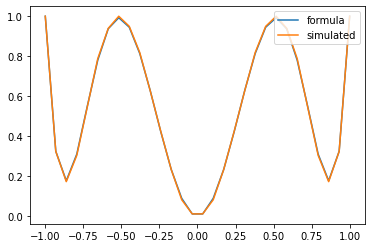

In [13]:
# Number of shots per x value (choose a higher x to increse the precision)
num_shots = 100

# Creates an experiment circuit based on x
def experiment_circuit(x):
    # Create circuit
    circ = qsp_circuit(x, phases)

    # Measure qubit
    circ.measure_all()

    # Transpile circuit
    return transpile(circ, backend)

ys_simulated = simulate_polynomial(experiment_circuit, xs, num_shots)

# Plot both evaluated probabilities `ys`` and simulated ones `simulated_ys``
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(xs, ys, label='formula')
ax.plot(xs, ys_simulated, label='simulated')
plt.legend(loc='upper right')
plt.show()

## 3. Projecting into the $\{|+\rangle, |-\rangle\}$ basis

In the previous section we projected the unitary into the $\{|0\rangle, |1\rangle\}$ basis, and we could compute $\langle 0|U^{\vec\phi}|0\rangle = P(x)$.
When projecting into the $\{|+\rangle, |-\rangle\}$ basis, we can construct a richer set of polynomials, since
$$
    \langle +|U^{\vec\phi}|+\rangle = \mathrm{Re}(P(x)) + \mathrm{i}\cdot\mathrm{Re}(Q(x))\cdot\sqrt{1 - x^2}
$$

In [14]:
# For now we want the polynomial symbolically for some variable 𝑥 and we use the same phases as above
x = sp.Symbol('x')
phases = [0.1, 0.2, 0.3, 0.4]

# This time we need to the entry in the top-right corner of the unitary
_, poly, qpoly = qsp_polynomial(x, phases)

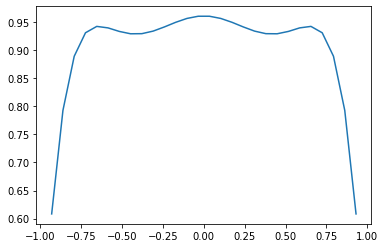

In [15]:
# translate amplitude polynomial into probability polynomial
sum_poly = sp.re(poly) + 1j * sp.re(qpoly / 1j)
sum_poly_abs = sp.Abs(sum_poly)**2

# we use the same number of discretization points
discretization_points = 30

# and evaluate the new polynomial for all values in xs
xs = np.linspace(-1, 1, discretization_points)
ys = [sum_poly_abs.evalf(subs={'x': x}) for x in xs]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(xs, ys)
plt.show()

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

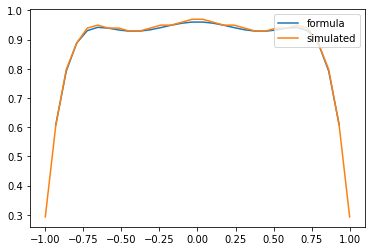

In [16]:
# Creates an experiment circuit based on x (this time adds H gates to the beginning and end)
def experiment_circuit(x):
    # Create circuit
    circ = qsp_circuit(x, phases)

    # Sandwich the circuit with H gates
    h_circ = QuantumCircuit(1)
    h_circ.h(0)
    circ = h_circ.compose(circ).compose(h_circ)

    # Measure qubit
    circ.measure_all()

    # Transpile circuit
    return transpile(circ, backend)

ys_simulated = simulate_polynomial(experiment_circuit, xs, num_shots)

# Plot both evaluated probabilities `ys`` and simulated ones `simulated_ys``
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(xs, ys, label='formula')
ax.plot(xs, ys_simulated, label='simulated')
plt.legend(loc='upper right')
plt.show()

## 4. Next steps

We hope you enjoyed our concrete demonstration of quantum signal processing. We encourage you to explore this notebook further, for example by:

* Trying out different phase angles to construct other polynomials.
* Changing the number of discretization points and number of shots to increase or decrease the precision of the plots.
* Trying out different backends: How would the 3D-bar plot look like when running on a real QPU? Just replace `ionq.simulator` by `ionq.qpu`.

To learn more about submitting Qiskit circuits to Azure Quantum, review [the Azure Quantum documentation](https://docs.microsoft.com/azure/quantum/quickstart-microsoft-qiskit?pivots=platform-ionq).

To learn more about job pricing, also review [the Azure Quantum documentation](https://docs.microsoft.com/azure/quantum/azure-quantum-job-costs).